In [1]:
import shutil
import random
import os

dataset_path = '/kaggle/input/human-faces-dataset/Human Faces Dataset'
real_images_path = os.path.join(dataset_path, 'Real Images')
ai_generated_images_path = os.path.join(dataset_path, 'AI-Generated Images')

output_path = '/kaggle/working/'
train_path = os.path.join(output_path, 'train')
val_path = os.path.join(output_path, 'val')
test_path = os.path.join(output_path, 'test')

for path in [train_path, val_path, test_path]:
    os.makedirs(os.path.join(path, 'Real Images'), exist_ok = True)
    os.makedirs(os.path.join(path, 'AI-Generated Images'), exist_ok = True)

train_split = 0.7
val_split = 0.15
test_split = 0.15

def split_and_copy_images(source_dir, dest_dirs, split_ratios):
    images = os.listdir(source_dir)
    random.shuffle(images)
    
    train_size = int(len(images) * split_ratios[0])
    val_size = int(len(images) * split_ratios[1])
    
    for i, img in enumerate(images):
        if i < train_size:
            dest_dir = dest_dirs[0]
        elif i < train_size + val_size:
            dest_dir = dest_dirs[1]
        else:
            dest_dir = dest_dirs[2]
            
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))

split_and_copy_images(real_images_path, [os.path.join(train_path, 'Real Images'), os.path.join(val_path, 'Real Images'), os.path.join(test_path, 'Real Images')], [train_split, val_split, test_split])
split_and_copy_images(ai_generated_images_path, [os.path.join(train_path, 'AI-Generated Images'), os.path.join(val_path, 'AI-Generated Images'), os.path.join(test_path, 'AI-Generated Images')], [train_split, val_split, test_split])

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 6741 images belonging to 2 classes.
Found 1444 images belonging to 2 classes.
Found 1445 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation ='relu')(x)
predictions = Dense(1, activation ='sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.6309 - loss: 0.6243 - val_accuracy: 0.8968 - val_loss: 0.3542
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9053 - loss: 0.3104 - val_accuracy: 0.9342 - val_loss: 0.2235
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9337 - loss: 0.2054 - val_accuracy: 0.9522 - val_loss: 0.1645
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9560 - loss: 0.1472 - val_accuracy: 0.9086 - val_loss: 0.2115
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9587 - loss: 0.1349 - val_accuracy: 0.9481 - val_loss: 0.1235
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9664 - loss: 0.1079 - val_accuracy: 0.9481 - val_loss: 0.1198
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9724 - loss: 0.0858 - val_accuracy: 0.9765 - val_loss: 0.0869
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.9795 - loss: 0.0717 - val_accurac

In [5]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9835 - loss: 0.0524
Test Loss: 0.051667045801877975
Test Accuracy: 0.9833909869194031


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


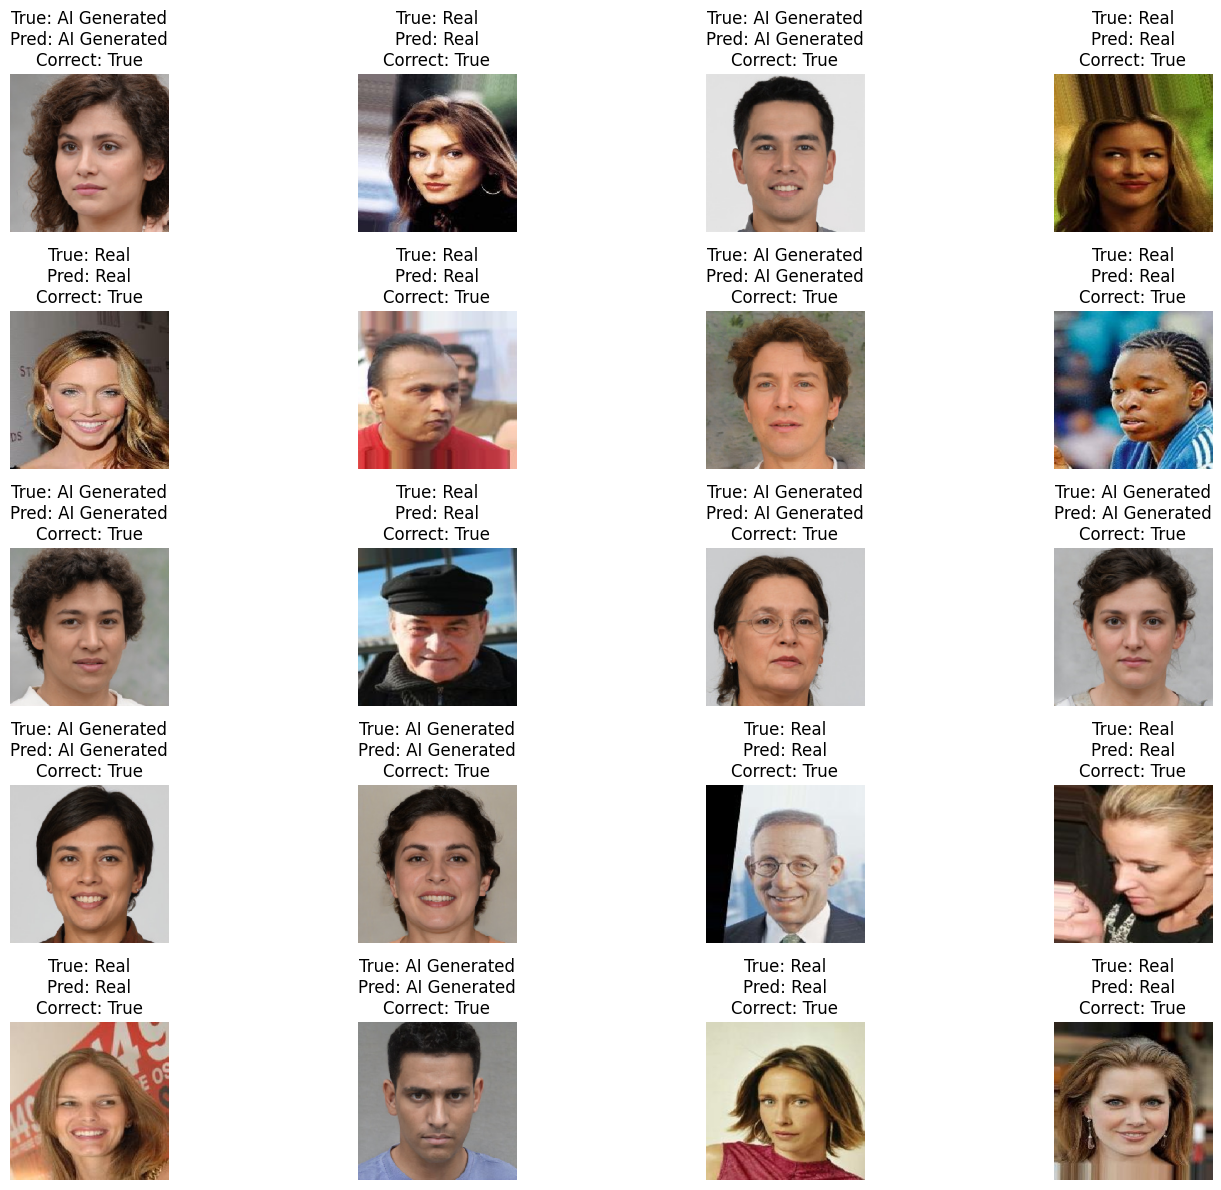

,Image Index,True Label,Predicted Label,Correct
0,0,AI Generated,AI Generated,True
1,1,Real,Real,True
2,2,AI Generated,AI Generated,True
3,3,Real,Real,True
4,4,Real,Real,True
5,5,Real,Real,True
6,6,AI Generated,AI Generated,True
7,7,Real,Real,True
8,8,AI Generated,AI Generated,True
9,9,Real,Real,True


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def show_predictions_table_with_correct_labels(model, generator, num_images = 20, threshold = 0.5):
    images, true_labels = next(generator)
    images, true_labels = images[:num_images], true_labels[:num_images]
    
    predictions = model.predict(images)
    predicted_labels = (predictions >= threshold).astype(int)
  
    if true_labels.ndim > 1:
        true_labels = np.argmax(true_labels, axis=1)
    
    true_label_names = ["Real" if label == 1 else "AI Generated" for label in true_labels]
    predicted_label_names = ["Real" if label == 1 else "AI Generated" for label in predicted_labels]
    correct_predictions = predicted_labels.flatten() == true_labels.flatten()

    df = pd.DataFrame({
        "Image Index": list(range(num_images)),
        "True Label": true_label_names,
        "Predicted Label": predicted_label_names,
        "Correct": correct_predictions
    })

    fig, axes = plt.subplots(5, 4, figsize = (15, 12))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {df['True Label'][i]}\nPred: {df['Predicted Label'][i]}\nCorrect: {df['Correct'][i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return df

show_predictions_table_with_correct_labels(model, val_generator, num_images = 20, threshold = 0.5)

In [ ]:
model.save("fake.h5")